In [3]:
#!export PATH=$PATH:/users/shoseini/.local/bin
#!echo $PATH
!python -m site --user-site
#!pip install --user diffusers
#!python3.9 -m venv paper2 # python3.8 -m venv env
#!python -m ipykernel install --user --name=paper2 --display-name "Python (paper2)"
#!which virtualenv
#!virtualenv /scratch/project_2012241/mnist/paper2
#!pip list
#!pip install diffusers
!python --version
#!pip list
!pip install diffusers --user
!pip show diffusers
#!export PATH=$PATH:~/.local/bin
#!source ~/.bashrc
!pip install  diffusers --prefix=./mnist/paper2/lib64/python3.9/site-packages/

C:\Users\hvory\AppData\Roaming\Python\Python312\site-packages
Python 3.12.4



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Name: diffusers
Version: 0.31.0
Summary: State-of-the-art diffusion in PyTorch and JAX.
Home-page: https://github.com/huggingface/diffusers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/diffusers/graphs/contributors)
Author-email: diffusers@huggingface.co
License: Apache 2.0 License
Location: C:\Users\hvory\AppData\Roaming\Python\Python312\site-packages
Requires: filelock, huggingface-hub, importlib-metadata, numpy, Pillow, regex, requests, safetensors
Required-by: 



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
#!pip install diffusers
#!pip cache purge
#!pip install --upgrade diffusers transformers
#!pip install --upgrade diffusers transformers
#!pip install --user transformers
!pip  install diffusers --user
#!pip install accelerate
from diffusers.models.autoencoders import AutoencoderKL
from transformers import AutoImageProcessor


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from dataclasses import dataclass
import torchvision
import torch
import os
import shutil
import torchvision.datasets as datasets
import torch.utils.data as data
import torchvision.transforms as transforms
from torch.utils.data import ConcatDataset, DataLoader, WeightedRandomSampler
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import UNet2DModel
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from accelerate import Accelerator
#from diffusers.utils.hub_utils import init_git_repo, push_to_hub
from datetime import datetime
import torch.nn.functional as F
from tqdm.auto import tqdm
from diffusers import DDPMPipeline

import math
from accelerate import notebook_launcher
from diffusers import DDPMPipeline
import glob
from torchvision.utils import save_image
from torchvision import datasets
from diffusers import DiffusionPipeline

In [163]:
@dataclass
class TrainingConfig:
    image_size = 28  # the generated image resolution
    train_batch_size = 16 #48
    eval_batch_size = 16 #48  # how many images to sample during evaluation
    test_batch_size=1
    num_epochs = 35
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 5
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir ='C:\\Users\\hvory\\ISSBA-main\\MNist\\mnist'  # the model namy locally and on the HF Hub
    log_dir="log"
    workers = 4

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

In [165]:
data_transforms = {
        'train': transforms.Compose([
            #transforms.RandomRotation(20),
           # transforms.RandomHorizontalFlip(0.5),
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            #transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ]),
        'val': transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((64, 64)),
            #transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
        ])
    }
data_dir="C:\\Users\\hvory\\ISSBA-main\\MNist\\mnist"
#bd_data_dir= "/scratch/project_2012241/bd_dataset/"
image_datasets = {'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])}
#poison_datasets= {x: datasets.ImageFolder(os.path.join(bd_data_dir, x), data_transforms[x])
                   # for x in ['train', 'val']}
#print(image_datasets)
#weights = [0.7]* len(image_datasets['train']) + [0.3] * len(poison_datasets['train'])
#print(weights)
#print([0.7] * len(image_datasets['train']))
# Create a WeightedRandomSampler to control the proportions
#sampler = WeightedRandomSampler(weights, len(weights))
#sampler = WeightedRandomSampler(weights, num_samples=70000, replacement=True)
#combined_dataset = ConcatDataset([image_datasets, poison_datasets])
#combined_dataset = ConcatDataset([image_datasets['train'], poison_datasets['train']])
#print(len(combined_dataset))
train_loader = data.DataLoader(image_datasets['train'], batch_size=config.train_batch_size, shuffle=False, num_workers=config.workers)
print(len(train_loader))
print(len(image_datasets['train']))

1243
19888


In [167]:
model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)


C:\Users\hvory\AppData\Local\Temp\ipykernel_17760\2232307372.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


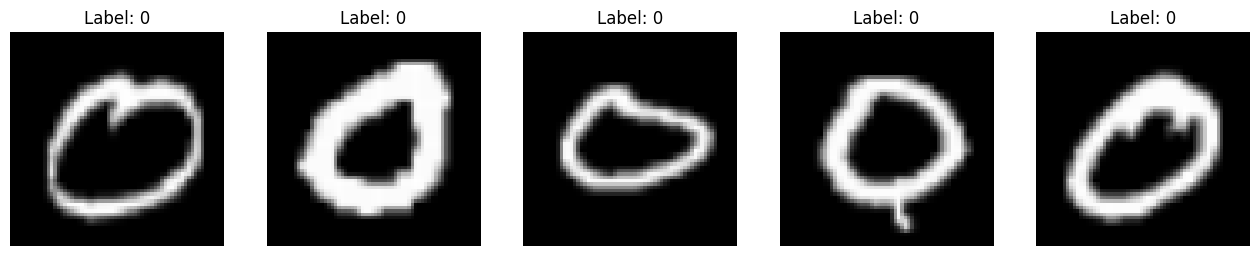

In [169]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(16, 4))
for i, (image, label) in enumerate(image_datasets['train']):

    axs[i].imshow(image.permute(1, 2, 0).numpy())
    axs[i].set_axis_off()
    axs[i].set_title(f"Label: {label}")


    if i >= 4: break
fig.show()

In [171]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_loader) * config.num_epochs),
)
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging, A list of loggers to be
    #setup for experiment tracking. Should be one or several of:"all","tensorboard","wandb"
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.log_dir, "logs")
    )
    if accelerator.is_main_process:
        #if config.push_to_hub:
            #repo = init_git_repo(config, at_init=True)
       # accelerator.init_trackers("train_example", log_with="tensorboard", logging_dir=os.path.join(config.output_dir, "logs"))
        accelerator.init_trackers("train_example")
       # accelerator.init_trackers("train_example")#, logging_dir=config.output_dir)
       
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(model, optimizer, train_dataloader, lr_scheduler)
    global_step = 0
    starttime = datetime.now()
    total_batches = len(train_dataloader) * config.num_epochs



    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")
        
        for step, batch in enumerate(train_dataloader):
            clean_images = batch[0]
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
            
            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()
            
            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
           
            with accelerator.accumulate(model):
                # Predict the noise residual
                #print(noisy_images.shape)
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            global_step += 1

            progress_bar.update(1)
            elapsed = datetime.now() - starttime
            total = elapsed * total_batches / global_step

            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            
        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                torch.autograd.set_detect_anomaly(True)
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                #if config.push_to_hub:
                    #push_to_hub(config, pipeline, repo, commit_message=f"Epoch {epoch}", blocking=True)
               # else:
                    pipeline.save_pretrained(config.output_dir) 
    torch.cuda.empty_cache()


In [173]:
def make_grid(images, rows, cols):
    w, h = images[0].size  # Get dimensions of the first image
    grid = Image.new('RGB', size=(cols*w, rows*h))  # create new blank image
    for i, image in enumerate(images):  # Paste images into the grid
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # config.eval_batch_size:This parameter specifies the number of images to generate in one batch.
    # The default pipeline output type is `List[PIL.Image]`
    #torch.manual_seed(config.seed):
    #you ensure that the image generation process can produce consistent results each time the code is run with the same seed
    #The .images attribute retrieves the generated images directly, typically as a tensor or a list of image objects.
    torch.autograd.set_detect_anomaly(True)
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples") # create folder samples
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")


In [177]:
args = (config, model, noise_scheduler, optimizer, train_loader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)
#num_processes: This should be set to the number of processes (GPUs) you want to use.


Launching training on one GPU.


  0%|          | 0/1243 [00:00<?, ?it/s]

RuntimeError: Function 'MseLossBackward0' returned nan values in its 0th output.

In [ ]:
trained_model = DiffusionPipeline.from_pretrained("output_dir").unet.to("cuda")
def show(tensor):
    return Image.fromarray((tensor.permute(0, 2, 3, 1) * 255.0).type(torch.uint8).numpy()[0])

#show(sample_image)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Add noise
noise_level = 100 #50

def noise(img, t):
    noise = torch.randn(img.shape)#.to(device)
    timesteps = torch.LongTensor([t])#.to(device)
    noisy_image = noise_scheduler.add_noise(img, noise, timesteps)
    return noisy_image

noisy_image = noise(sample_image, noise_level)
print(sample_image.size)
print(noisy_image.shape)
save_image(noisy_image, "denoised_images/noisy_image.png")
#show(noisy_image)

In [ ]:
@torch.no_grad()
def denoise(img, ts, progress=True):
    noise_scheduler.set_timesteps(1000)
    img_reconstruct = img[0].unsqueeze(0).to("cuda")
    #img_reconstruct = img.reshape(1, 3, config.image_size, config.image_size).to("cuda")

    for t in tqdm(noise_scheduler.timesteps[-ts:], disable=not progress):
        # 1. predict noise model_output
        model_output = trained_model(img_reconstruct, t).sample

        # 2. compute previous img_reconstruct: x_t -> x_t-1
        img_reconstruct = noise_scheduler.step(model_output, t, img_reconstruct).prev_sample
        #print(reconstructed)
    return img_reconstruct


img_reconstruct = denoise(noisy_image, noise_level)

In [ ]:
reconstructed = img_reconstruct.detach().cpu()
print(type(reconstructed))
#reconstructed.save("denoised_images")
save_image(reconstructed, "denoised_images/saved_image.png")
#show(reconstructed)

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

images = dict(
    sample_image=sample_image,
    noisy_image=noisy_image,
    reconstructed=reconstructed,
)

for i, (title, image) in enumerate(images.items()):
    axs[i].imshow(show(image))
    axs[i].set_axis_off()
    axs[i].set_title(title)
fig.suptitle(f"Reconstruction at $t=${noise_level}", fontsize=14);

In [ ]:
def noise(img, t):
    noise = torch.randn(img.shape)#.to(device)
    timesteps = torch.LongTensor([t])#.to(device)
    noisy_image = noise_scheduler.add_noise(img, noise, timesteps)
    return noisy_image

In [ ]:
@torch.no_grad()
def denoise(img, ts, progress=True):
    noise_scheduler.set_timesteps(1_000)
    img_reconstruct = img[0].unsqueeze(0).to("cuda")
    #img_reconstruct = img.reshape(1, 3, config.image_size, config.image_size).to("cuda")

    for t in tqdm(noise_scheduler.timesteps[-ts:], disable=not progress):
        # 1. predict noise model_output
        model_output = trained_model(img_reconstruct, t).sample

        # 2. compute previous img_reconstruct: x_t -> x_t-1
        img_reconstruct = noise_scheduler.step(model_output, t, img_reconstruct).prev_sample

    return img_reconstruct


In [ ]:
noise_level = 100 #50
from PIL import Image
import shutil
lst_dir=[]
#test_loader = data.DataLoader(image_datasets['train'], batch_size=config.test_batch_size, shuffle=True, num_workers=config.workers)
for idx, (originImg, label) in enumerate(image_datasets['train']):
        file_path = image_datasets['train'].samples[idx][0]
        file_name = os.path.splitext(os.path.basename(file_path))[0]    #[0]
        originImg=originImg.unsqueeze(0)
        os.makedirs("clean_dataset", exist_ok=True)
        noisy_image = noise(originImg, noise_level)
        img_reconstruct = denoise(noisy_image, noise_level)
        reconstructed = img_reconstruct.detach().cpu()
        folder_path = os.path.join('/scratch/project_2012241/mnist' , 'train') 
        newfile= file_name
        lst_dir.append(newfile)
        os.makedirs(folder_path + "\\" + newfile, exist_ok=True)
        newfolder=os.path.join(folder_path,newfile)
        Image.fromarray((noisy_image.permute(0, 2, 3, 1) * 255).type(torch.uint8).numpy()[0])
        image_path = os.path.join(newfolder, file_name + ".png")
        save_image(reconstructed, image_path)
        os.makedirs(folder_path + "\\" + newfile, exist_ok=True)
        newfolder=os.path.join(folder_path,newfile)
        image_path = os.path.join(newfolder, file_name + ".png")
        save_image(reconstructed, image_path)
